In [1]:
# Copyright © 2022-​2024 ETH Zurich, Mattia Gollub; D-BSSE; CSB group

import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple
from scipy.stats import pearsonr
from scipy import stats

plt.rcParams["font.family"] = "Helvetica"
group_palette = ["#96BCE0", "#926AAD", "#AFC286", "#B8772F"]
method_palette = ["#A64C4D", "#40609B"]
CAPSIZE = 0.05
ERRWIDTH = 1.5
DATA_DIR = pathlib.Path("../data")
RESULTS_DIR = pathlib.Path("../data/results")
FIGURES_DIR = pathlib.Path("../data/figures")
SPLITS_DIR = pathlib.Path("../data/databases/splits")
KM = r"$K_M$"
KCAT = r"$k_{cat}$"
GB = "Gradient Boosting"
BMM = "Bayesian Multilevel Models"

In [2]:
def norm_log_pdf(errors: np.ndarray, sds: np.ndarray) -> np.ndarray:
    var = np.square(sds)
    denom = np.sqrt(2 * np.pi * var)
    num = np.exp(-(errors**2) / (2 * var))
    return np.log(num / denom)


def rmse(errors: np.ndarray) -> float:
    return np.sqrt(np.mean(np.square(errors)))

## Load datasets of measured and predicted values for Km and Kcat

In [3]:
# Load KM data.
km_test_df = pd.read_csv(RESULTS_DIR / "kroll_2021" / "km_4.csv")
kroll_km_test_df = pd.read_excel(
    DATA_DIR / "comparison_kroll_2021/Figure_4.xlsx",
    sheet_name="Figure 4 - panel c (blue dots)",
)
kroll_km_test_df.columns = ["predicted", "value"]
km_test_df["pred_kroll"] = kroll_km_test_df["predicted"]
km_test_df["error_kroll"] = np.abs(km_test_df["pred_kroll"] - km_test_df["value"])

# Load kcat data.
kcat_test_df = pd.read_csv(RESULTS_DIR / "kroll_2022" / "kcat_4.csv")
kcat_test_df["pred_kroll"] = np.load(
    DATA_DIR / "comparison_kroll_2022/y_test_pred_xgboost_ESM1b_ts_DRFP_mean.npy"
)
kcat_test_df["error_kroll"] = np.abs(kcat_test_df["pred_kroll"] - kcat_test_df["value"])

print("RMSE:")
print(
    f"KM   - ENKIE: {rmse(km_test_df['error']):.2f}, Kroll et al., 2021: {rmse(km_test_df['error_kroll']):.2f}"
)
print(
    f"kcat - ENKIE: {rmse(kcat_test_df['error']):.2f}, Kroll et al., 2022: {rmse(kcat_test_df['error_kroll']):.2f}"
)

RMSE:
KM   - ENKIE: 0.87, Kroll et al., 2021: 0.81
kcat - ENKIE: 0.95, Kroll et al., 2022: 0.89


In [53]:
rmse_km_df = pd.DataFrame(
    {
        "pred_error": np.full(len(km_test_df), rmse(km_test_df["error"])),
        "error": km_test_df["error"].values,
    }
)
rmse_kcat_df = pd.DataFrame(
    {
        "pred_error": np.full(len(kcat_test_df), rmse(kcat_test_df["error"])),
        "error": kcat_test_df["error"].values,
    }
)
simulation_km_df = pd.DataFrame(
    {
        "pred_error": km_test_df["pred_error"].values,
        "error": np.abs(
            km_test_df["pred_error"].values * np.random.randn(len(km_test_df))
        ),
    }
)
simulation_kcat_df = pd.DataFrame(
    {
        "pred_error": kcat_test_df["pred_error"].values,
        "error": np.abs(
            kcat_test_df["pred_error"].values * np.random.randn(len(kcat_test_df))
        ),
    }
)

c:\Users\matti\anaconda3\envs\enkie\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


PearsonRResult(statistic=nan, pvalue=nan)
PearsonRResult(statistic=0.24939623912051237, pvalue=1.6964486286878218e-34)
PearsonRResult(statistic=0.3137819716139165, pvalue=1.3173999481426823e-54)


c:\Users\matti\anaconda3\envs\enkie\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


PearsonRResult(statistic=nan, pvalue=nan)
PearsonRResult(statistic=0.2767779074641158, pvalue=2.058895775741591e-16)
PearsonRResult(statistic=0.3076774602187365, pvalue=4.2837527975146566e-20)


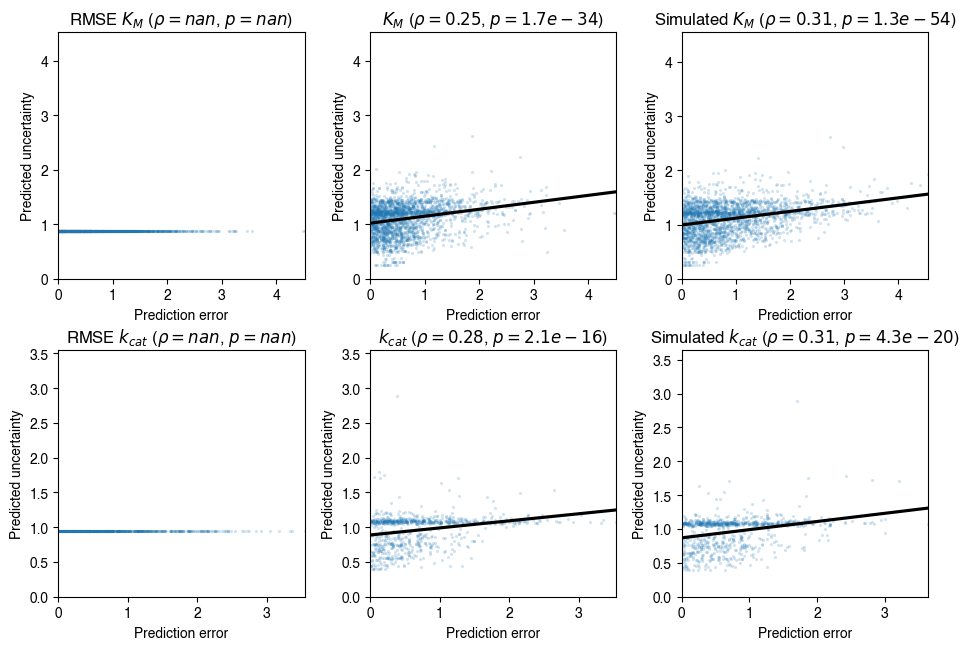

In [54]:
def plot_scatter(
    df: pd.DataFrame,
    title: str,
    ax: plt.Axes,
) -> None:
    x = "error"
    y = "pred_error"
    test = pearsonr(df[x], df[y])
    print(test)
    sns.scatterplot(data=df, x=x, y=y, ax=ax, linewidth=0, s=5, alpha=0.2)
    if np.isfinite(test.statistic):
        sns.regplot(data=df, x=x, y=y, ax=ax, scatter=False, color="black", ci=None)

    ax.set_xlabel("Prediction error")
    ax.set_ylabel("Predicted uncertainty")
    ax.set_title(f"{title} ($\\rho={test.statistic:.2f}$, $p={test.pvalue:.1e}$)")
    ax.set_aspect("equal", adjustable="box")
    max_lim = max(df[x].max(), df[y].max())
    ax.set_xlim(0, max_lim)
    ax.set_ylim(0, max_lim)


fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2, 3, figsize=(9.5, 6.5))

plot_scatter(rmse_km_df, "RMSE $K_M$", ax0)
plot_scatter(km_test_df, "$K_M$", ax1)
plot_scatter(simulation_km_df, "Simulated $K_M$", ax2)

plot_scatter(rmse_kcat_df, "RMSE $k_{{cat}}$", ax3)
plot_scatter(kcat_test_df, "$k_{{cat}}$", ax4)
plot_scatter(simulation_kcat_df, "Simulated $k_{{cat}}$", ax5)

fig.tight_layout()


fig.savefig(FIGURES_DIR / "error_uncertainty_correlation.pdf", bbox_inches="tight")